# 01 - Detect data bias

Let's first load our challenge dataset into a pandas dataframe. The dataset was downloadded from kaggle.

In [1]:
import pandas as pd

loan_dataset = pd.read_csv("../datasets/loan.csv")
loan_dataset.head()

,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,year,job_stability,default,occupation
0,minority-yes,male,MT04PA,1,57.230650,36.050927,205168.022244,7600.292199,3.302193,0,3.015554,default-yes,MZ10CD
1,minority-yes,male,MT04PA,1,45.891343,59.525251,187530.409981,5534.271289,3.843058,0,5.938132,default-yes,MZ10CD
2,minority-yes,male,MT04PA,1,46.775489,67.338108,196912.006690,2009.903438,2.059034,0,2.190777,default-yes,MZ10CD
3,minority-yes,male,MT04PA,1,41.784839,24.067401,132911.650615,3112.280893,3.936169,0,1.725860,default-yes,MZ10CD
4,minority-yes,male,MT04PA,1,41.744838,47.496605,161162.551205,1372.077093,3.709910,0,0.883104,default-yes,MZ10CD


Let's inspect the columns of the dataset. These will be the features for our prediction problem, but also contain the __outcome variable__, that is, the variable to be predicted:

In [2]:
loan_dataset.columns

Index(['minority', 'sex', 'ZIP', 'rent', 'education', 'age', 'income',
       'loan_size', 'payment_timing', 'year', 'job_stability', 'default',
       'occupation'],
      dtype='object')

Let's inspect the number of observations (`n_samples`) that our dataset has:

In [3]:
print(f"Number of observations: {len(loan_dataset)}")

Number of observations: 480000


Let's define which features of the dataset are numerical and which categorical:



In [4]:
# Define categorical features
categorical_features = ["sex", "rent", "minority", "ZIP", "occupation"]

# Define numeric features
numeric_features = [
    "education", "age", "income", "loan_size", "payment_timing",
    "year", "job_stability"
]

# Set dtype for categorical features
for cat in categorical_features:
    loan_dataset[cat] = loan_dataset[cat].astype("object")

Let's create the `X` and `y` that will be the input of our machine learning algorithm:

In [5]:
# Define X
X = loan_dataset.copy().drop(["minority", "default"], axis=1)

# Define y
y = loan_dataset.copy()["default"]

To detect dataset, bias, we first need to define which will be our __sensitive features__. That is, the features that the modeler should take into account when evaluating the fairness of the data or algorithm. In our case we will define `minority` and `sex` as sensitive features:

In [6]:
# Define sensitive features:
sensitive_features = ["minority", "sex"]

Let's inspect if the number of observations is __balanced__ with respect to each sensitive feature:

In [7]:
for f in sensitive_features:
    print(f"Number of occurrances per `{f}` value:")
    balance_samples_df = loan_dataset[f].copy().value_counts()
    display(balance_samples_df)
    print("\n")

Number of occurrances per `minority` value:


minority-no     240167
minority-yes    239833
Name: minority, dtype: int64



Number of occurrances per `sex` value:


male      240000
female    240000
Name: sex, dtype: int64

Let's also inspect the number of observations per sensitive feature and values of the outcome variable:

In [8]:
for f in sensitive_features:
    print(f"Number of occurrances per `{f}` value:")
    balance_outcome_df = loan_dataset.copy().groupby([f, "default"]).size()
    balance_outcome_df.name = "number"
    display(balance_outcome_df)
    print("\n")

Number of occurrances per `minority` value:


minority      default    
minority-no   default-no     239818
              default-yes       349
minority-yes  default-no        255
              default-yes    239578
Name: number, dtype: int64



Number of occurrances per `sex` value:


sex     default    
female  default-no     120073
        default-yes    119927
male    default-no     120000
        default-yes    120000
Name: number, dtype: int64

Let's know inspect how __sensitive features relate__ to __other categorical features__.

In [9]:
for f in sensitive_features:
    print(f"This is how {f} releates to other categorical features:")
    grouped_dataset = loan_dataset.copy().set_index(f)
    categorical_dataset = (
        grouped_dataset.copy().select_dtypes(include=["object", "bool"])
    )
    categorical_dataset = pd.get_dummies(categorical_dataset)
    display(categorical_dataset.groupby(level=0).count())
    print("\n")

This is how minority releates to other categorical features:


,sex_female,sex_male,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,rent_0,rent_1,default_default-no,default_default-yes,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
minority,,,,,,,,,,,,,
minority-no,240167,240167,240167,240167,240167,240167,240167,240167,240167,240167,240167,240167,240167
minority-yes,239833,239833,239833,239833,239833,239833,239833,239833,239833,239833,239833,239833,239833




This is how sex releates to other categorical features:


,minority_minority-no,minority_minority-yes,ZIP_MT01RA,ZIP_MT04PA,ZIP_MT12RA,ZIP_MT15PA,rent_0,rent_1,default_default-no,default_default-yes,occupation_MZ01CD,occupation_MZ10CD,occupation_MZ11CD
sex,,,,,,,,,,,,,
female,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000
male,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000,240000


Let's also plot these relationships:

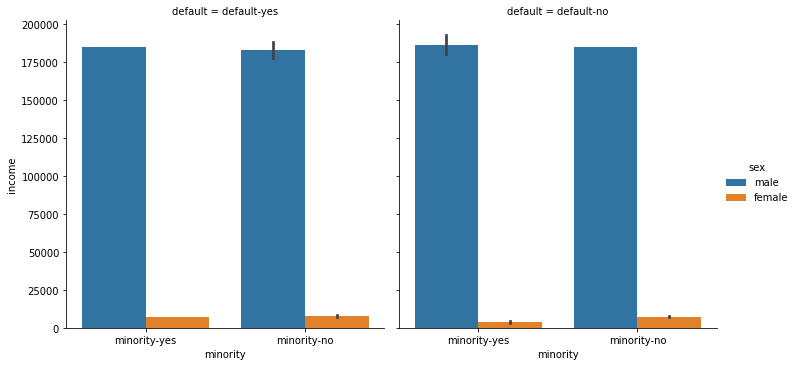

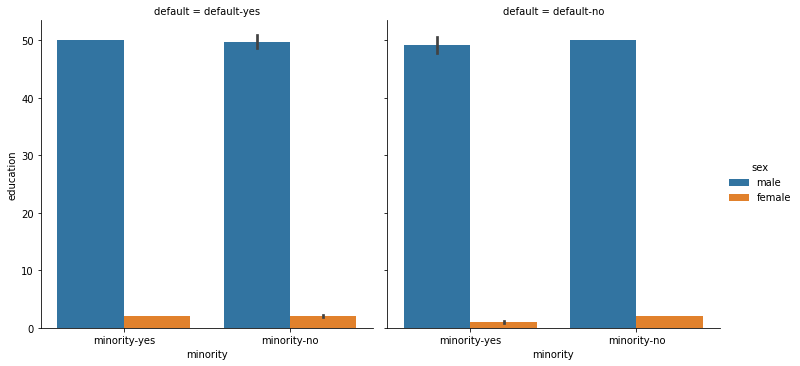

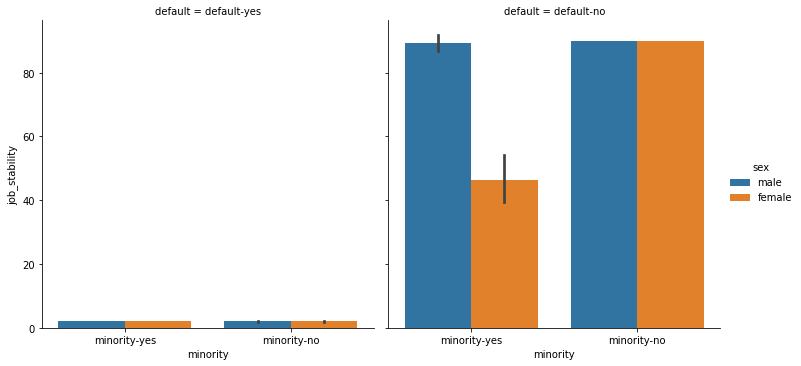

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot categorical plots
sns.catplot(x="minority", y="income", hue="sex", data=loan_dataset, col="default", kind="bar")
sns.catplot(x="minority", y="education", hue="sex", data=loan_dataset, col="default", kind="bar")
sns.catplot(x="minority", y="job_stability", hue="sex", data=loan_dataset, col="default", kind="bar")

Let's know inspect how __sensitive features relate__ to __other continuous features__.

In [11]:
for f in sensitive_features:
    print(f"This is how {f} relates to other continuous variables")
    display(loan_dataset.groupby(f).mean())
    print("\n")

This is how minority relates to other continuous variables


,education,age,income,loan_size,payment_timing,year,job_stability
minority,,,,,,,
minority-no,26.004133,43.005323,96153.156204,5001.262974,2.998046,14.502538,89.863856
minority-yes,26.039383,42.968505,96294.198185,5008.746145,3.001442,14.497459,2.061528




This is how sex relates to other continuous variables


,education,age,income,loan_size,payment_timing,year,job_stability
sex,,,,,,,
female,2.006860,42.983031,7419.333176,5010.193518,2.997546,14.5,45.988904
male,50.036632,42.990822,185027.923071,4999.810394,3.001940,14.5,45.997575


Let's plot the relationship between __minority__ and other __continuous features__:

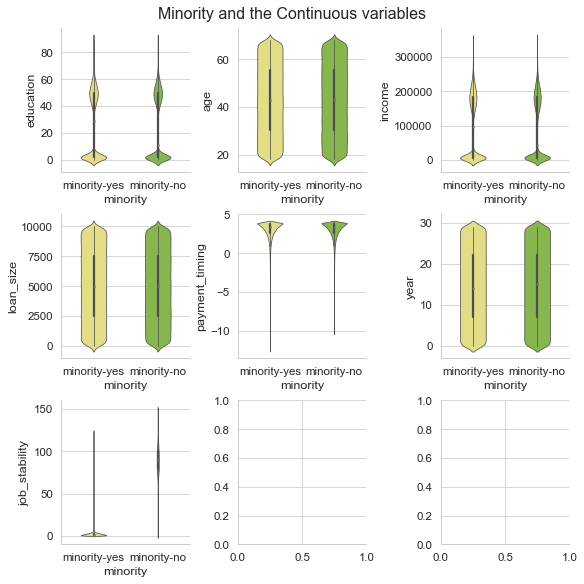

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set sns configuration
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.3)     
colors = ["#F4EA77", "#89C63D"]
sns.set_palette(sns.color_palette(colors))

# Plot figure
nrows = int(len(numeric_features)/2)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8), constrained_layout=True)
fig.suptitle("Minority and the Continuous variables", fontsize=16)
axes = axes.flatten()
for c, num_col in enumerate(numeric_features):
    sns.violinplot(x="minority", y=num_col, data=loan_dataset, 
                   width=0.4, ax=axes[c],
                   linewidth=0.75)
    sns.despine()

Let's plot the relationship between __sex__ and other __continuous features__:

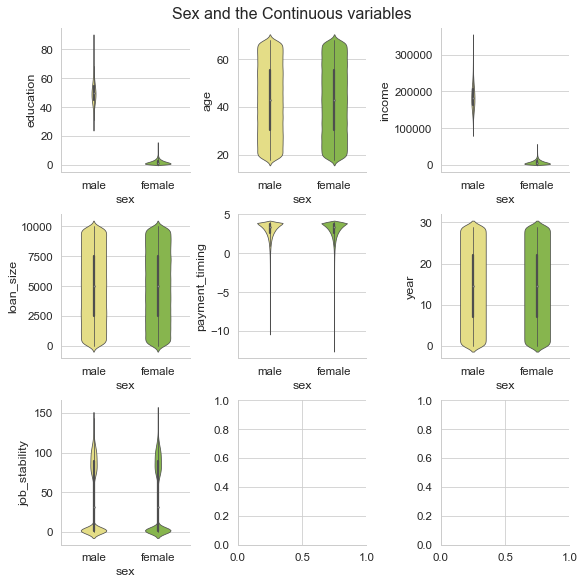

In [13]:
# Plot figure
nrows = int(len(numeric_features)/2)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8), constrained_layout=True)
fig.suptitle("Sex and the Continuous variables", fontsize=16)
axes = axes.flatten()
for c, num_col in enumerate(numeric_features):
    sns.violinplot(x="sex", y=num_col, data=loan_dataset, 
                   width=0.4, ax=axes[c],
                   linewidth=0.75)
    sns.despine()

## Conclusions

Overall, in our dataset it seems that:
- __Minorities have lower job stability__ than non-minorities
- __Men have higher education__ than woman
- There is __no imbalance in the number__ of samples for each sensitive features
